## 0. Initialization

<b>Please execute this first cell now!</b> This will initialize some configurations and import all the necessary packages that we need.

In [9]:
import torch
import copy
import numpy as np
from crai.climatereconstructionai.model.net import CRAINet
from crai.climatereconstructionai.utils.netcdfloader import NetCDFLoader, InfiniteSampler
from tqdm import tqdm
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import xarray as xr
# from utils import initialize_config, plot_sample, plot_results, create_video

# initialize_config() # don't bother with this!

In [5]:
ds = xr.open_dataset('era5_data/2dcb2b55780e1879d0607ef1ac3473enc49.nc')
ds

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 696, lon: 17, lat: 17)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-02-01 ... 2020-02-29T23:00:00
  * lon      (lon) float64 136B 14.36 14.61 14.86 15.11 ... 17.86 18.11 18.36
  * lat      (lat) float64 136B 50.23 49.98 49.73 49.48 ... 46.73 46.48 46.23
Data variables:
    var165   (time, lat, lon) float32 805kB ...
    var166   (time, lat, lon) float32 805kB ...
    var168   (time, lat, lon) float32 805kB ...
    var167   (time, lat, lon) float32 805kB ...
    var134   (time, lat, lon) float32 805kB ...
    var228   (time, lat, lon) float32 805kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Nov 06 16:51:21 2024: cdo -f nc4 copy era5_data/2dcb2b5...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

## 1. Data Preparation

Before we can start loading our data, we need to specify some configurations. Here are some of the important configurations for the data loading process:
<ul>
    <li><b>data_root:</b> The root directory of your data. This should contain the subdirectories <i>train/</i>, <i>val/</i> and <i>test/</i> for the training, validation and test data</li>
    <li><b>data_name:</b> The name of the data file in the data-root directory</li>
    <li><b>mask_dir:</b> The directory where the NetCDF4 file of the mask is stored</li>
    <li><b>mask_name:</b> The name of the mask file in the mask directory</li>
    <li><b>variable:</b> The variable name in the NetCDF4 file</li>
</ul>

In [13]:
ds = xr.open_dataset('crai_radolan_ferdinand/train/vienna_t2m_2017-2024_data_cropped_era5.nc')
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12477, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 100kB 2017-04-24T14:00:00 ... 2022-05-24T1...
  * lon      (lon) float64 64B 15.5 15.75 16.0 16.25 16.5 16.75 17.0 17.25
  * lat      (lat) float64 64B 47.25 47.5 47.75 48.0 48.25 48.5 48.75 49.0
Data variables:
    var167   (time, lat, lon) float32 3MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Wed Oct 30 22:21:53 2024: cdo mergetime /home/k/k202207/ERA...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

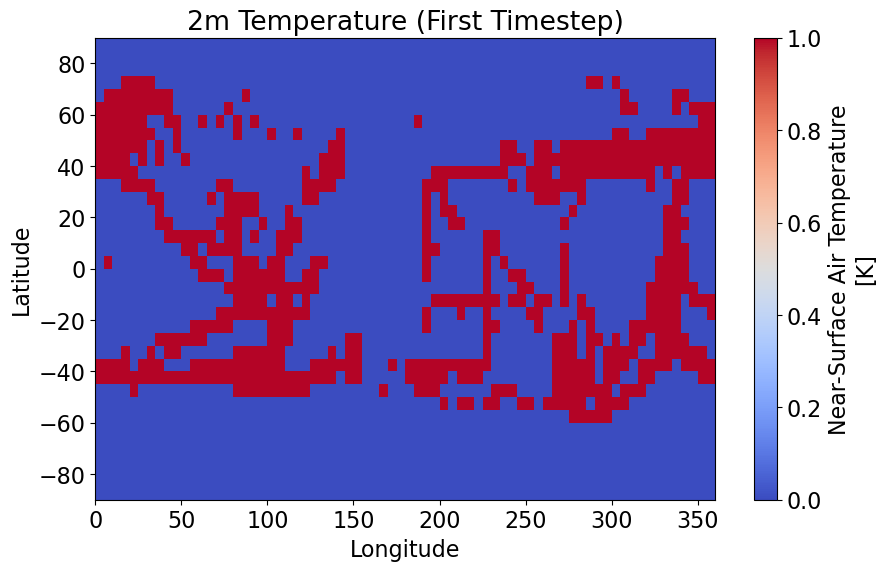

In [11]:
# example mask 1 where have values 0 where not 
ds = xr.open_dataset('crai/data/hadcrut_missmask_1.nc')

t2m_first_timestep = ds['tas']
# Plotting
plt.figure(figsize=(10, 6))
t2m_first_timestep.plot(cmap='coolwarm')
plt.title("2m Temperature (First Timestep)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [17]:
# define data parameters
data_root = "crai_radolan_ferdinand/"
data_name = "vienna_t2m_2017-2024_data_cropped_era5.nc" # need to be cropped data with matching timesteps could mayebe be a list with output in the end
mask_dir = [] # no mask crai will create a mask where we don not have NaNs
mask_name = [] # no mask 
variable = "var167"

After defining the parameters, we can set up our data set. For this, climatereconstructionai implements a custom data set "NetCDFLoader" that is able to read in NetCDF4 files and applies preprocessing in the background. We use the data in the "train/" directory as our training data and the data in the "val/" directory as our validation data.

In [18]:
dataset_train = NetCDFLoader(data_root, [data_name], mask_dir, [mask_name], "train", [variable], [0, 0]) # timestep [0,0] only look at one timestep no future and past 


AttributeError: module 'crai.climatereconstructionai.config' has no attribute 'loop_random_seed'

In [4]:
# create data set
# Dataloader comment: splits betwwen cpu and gpu, cpu prepares, gpu proccesses, NetCDFloader creates tensor
dataset_train = NetCDFLoader(data_root, [data_name], mask_dir, [mask_name], "train", [variable], [0, 0]) # timestep [0,0] only look at one timestep no future and past 
dataset_val = NetCDFLoader(data_root, [data_name], mask_dir, [mask_name], "val", [variable], [0, 0])

To see, how many samples our data set consists of, we can call the "__len__()" function. Also, we can access a data sample from the data set by calling the "__getitem__()" function and passing an index within the range of the data set length. Each sample consists of a tuple of three elements: the image, which is the ground truth masked with a missing value field, the mask itself and the ground truth with no missing values:

79521


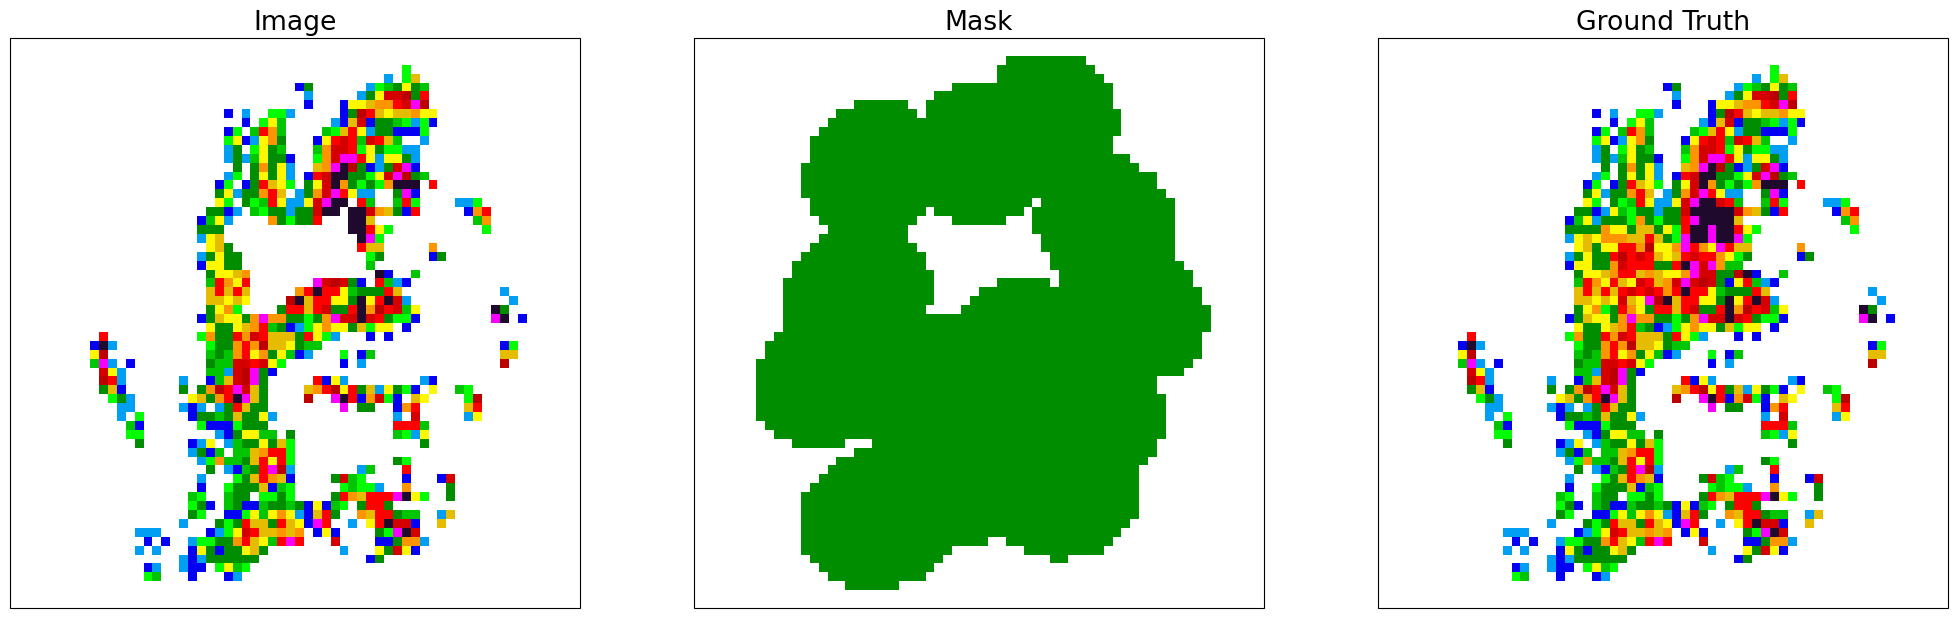

In [5]:
# print the length of the data set
print(dataset_train.__len__())

# sample and plot a single sample
image, mask, gt, _ = dataset_train.__getitem__(8350)
plot_sample(image, mask, gt)

In PyTorch, a data set is generally combined with a data loader. The data loader is used to efficiently sample data from our data set during training. Here, we can define how many samples should be loaded at once (batch-size) and by how many threads this data should be loaded in parallel to the training (number-of-threads). By wrapping the data loader around a python iterator, we can easily iterate the whole data set by calling the next() function on the data loader. This will return a set of random samples from our data set.

In [42]:
# data loader parameters
batch_size = 64 # higher number, better approximation of data, model updated after entire batch, small batch size = noisy
number_of_threads = 6 # specifies number of workers, multiprocessing, has an effect in preprocessing routine and speed

# create data loader
iterator_train = iter(DataLoader(dataset_train, batch_size=batch_size,
                                 sampler=InfiniteSampler(len(dataset_train)),
                                 num_workers=number_of_threads))
iterator_val = iter(DataLoader(dataset_val, batch_size=batch_size,
                               sampler=InfiniteSampler(len(dataset_val)),
                               num_workers=number_of_threads))

## 2. Model Definition

In this section, we define our model. Here are two useful parameters to play with, that change the model architecture:
<ul>
    <li><b>encoding_layers:</b> Defines the number of encoding layers for the model</li>
    <li><b>pooling_layers:</b> Defines the number of pooling layers for the model</li>
</ul>

In [43]:
# define model parameters
encoding_layers = 3 
pooling_layers = 1
# decreases image size by to so 2**layers < size

# model definition
model = CRAINet(img_size=dataset_train.img_sizes[0],
                enc_dec_layers=encoding_layers,
                pool_layers=pooling_layers,
                in_channels=1,
                out_channels=1,
                bounds=dataset_train.bounds)

print(model)

CRAINet(
  (encoder): ModuleList(
    (0): EncoderBlock(
      (partial_conv): PConvBlock(
        (input_conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (mask_conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (activation): ReLU()
      )
    )
    (1): EncoderBlock(
      (partial_conv): PConvBlock(
        (input_conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (mask_conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (activation): ReLU()
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): EncoderBlock(
      (partial_conv): PConvBlock(
        (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (activation): ReLU()
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## 3. Model Training

In this section, we define our loss function and train our model. We added a set of different configuration parameters training for your own needs. Here are some useful parameters:
<ul>
    <li><b>learning_rate:</b> The learning rate for the back-propagation</li>
    <li><b>save_model_interval:</b> The interval after which iterations the current state of the model should be saved</li>
    <li><b>max_iterations:</b> The number of iterations of the training cycle</li>
    <li><b>device:</b> "cpu", if the model should be trained on the CPU, or "cuda", if the model should be trained on a GPU</li>
</ul>

In [44]:
# define training parameters
learning_rate = 2e-3
save_model_interval = 1000
max_iterations = 20000
device = "cuda"

Next, we need to define a loss function, that determines on which criterion the model should be trained on. The L1 loss compares the ground truth with the model output by calculating the absolute difference between both: |L1 = gt - output|. The optimizer defines how the calculated loss should be applied to update the model which is also influenced by the learning rate.

In [45]:
# define loss function
loss = torch.nn.L1Loss()

# define optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

During training of the model, the program iterates the whole data set a fixed number of times which we defined in "max_iterations". 

In [46]:
train_losses = []
val_losses = []
models = {}

# push model to device
model = model.to(torch.device(device))

# monitoring the training progress
progress_bar = tqdm(range(0, max_iterations))
for i in progress_bar:
    n_iterations = i + 1

    # avtivate train mode
    model.train()

    # sample data
    image, mask, gt = [x.to(torch.device(device)) for x in next(iterator_train)[:3]]

    # forward step
    output = model(image, mask)

    # calculate the loss
    train_loss = loss(output, gt)

    # back-propagation step
    optimizer.zero_grad() # deletes all gradients before step
    train_loss.backward()
    optimizer.step()
    
    # calculate validation loss
    image_val, mask_val, gt_val = [x.to(torch.device(device)) for x in next(iterator_val)[:3]]
    model.eval()
    with torch.no_grad():
        output_val = model(image_val, mask_val)
    val_loss = loss(output_val, gt_val)

    # save loss values
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # save model at current state
    if n_iterations % save_model_interval == 0:
        models[n_iterations] = copy.deepcopy(model)

100%|██████████| 20000/20000 [06:16<00:00, 53.10it/s]


After the training has completed, we can take a look at the loss function during the training progress. The loss values were stored in the log file in the previously defined interval. We can read this file and plot the results with the following function:

In [ ]:
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Loss over iterations")


n_win = 100
plt.plot(np.convolve(train_losses, np.ones(n_win), "valid")/n_win, label="Train")
plt.plot(np.convolve(val_losses, np.ones(n_win), "valid")/n_win, label="Val")
plt.legend()

Since we don't have unlimited time, the model maybe could have needed a few more iterations until it reached an optimal state. However, we can also observe that the loss is at a quite low value already.

## 4. Model Evaluation

After we finished our training, we can use this model to apply some infilling of our test data, which the model hasn't seen so far. This data is stored in the data's <i>test/</i> subdirectory. Therefore, we define the iterations, where we saved a model, from which we want to infill the data.

In [37]:
# create validation data set
dataset_val = NetCDFLoader(data_root, [data_name], mask_dir, [mask_name], "infill", [variable], [0, 0])
inputs = torch.stack([dataset_val.__getitem__(i)[0] for i in range(dataset_val.__len__())]).to(torch.device("cpu"))
masks = torch.stack([dataset_val.__getitem__(i)[1] for i in range(dataset_val.__len__())]).to(torch.device("cpu"))
gts = torch.stack([dataset_val.__getitem__(i)[2] for i in range(dataset_val.__len__())]).to(torch.device("cpu"))

infill_iterations = [1000, 5000, 10000]
outputs = {}

# iterate through models and save predictions
for iteration in infill_iterations:
    model = models[iteration].to(torch.device("cpu"))
    model.eval()

    with torch.no_grad():
        outputs[iteration] = model(inputs, masks)

In [38]:
infilled = {}
for iteration in infill_iterations:
    infilled[iteration] = (1 - masks) * outputs[iteration] + masks * inputs

Now we can plot this data, comparing the output of early stage models with the models of later stages.

Iteration: 1000


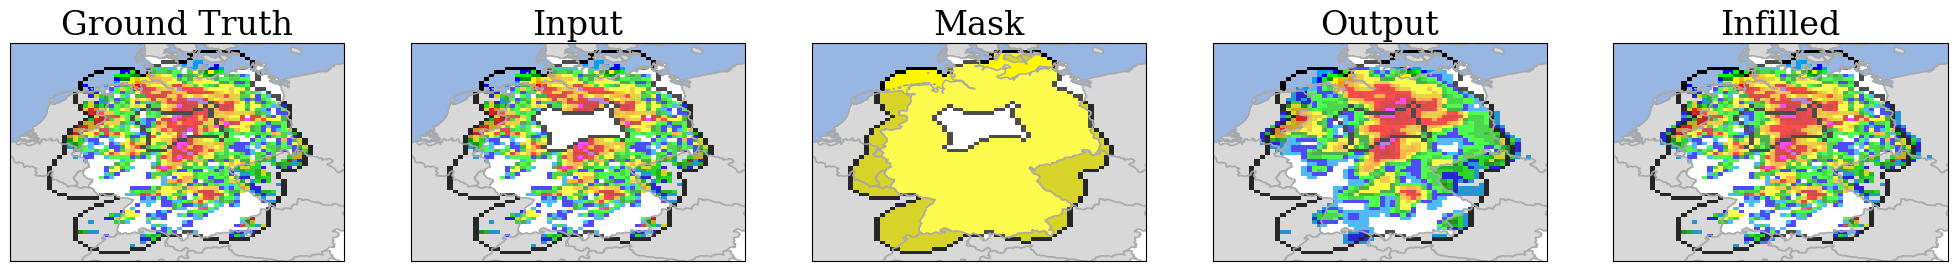

Iteration: 5000


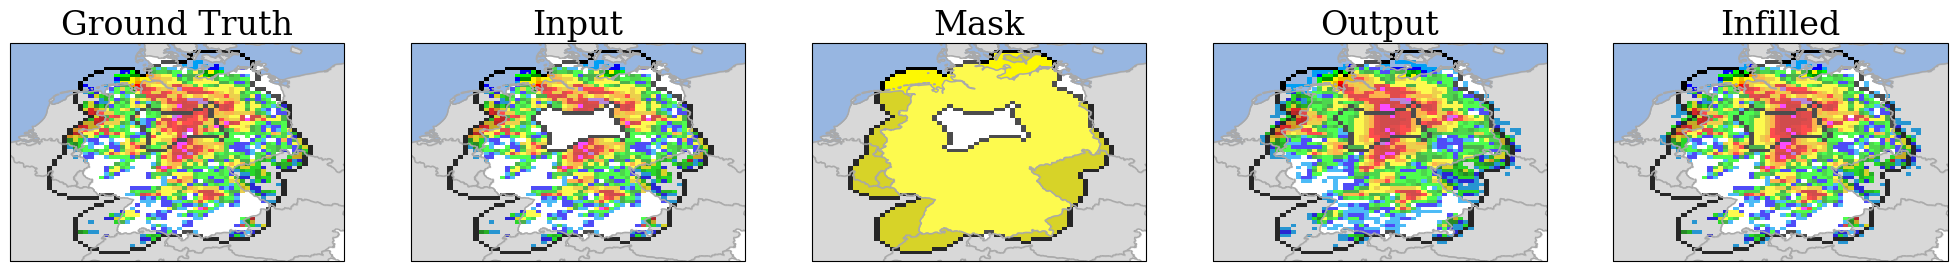

Iteration: 10000


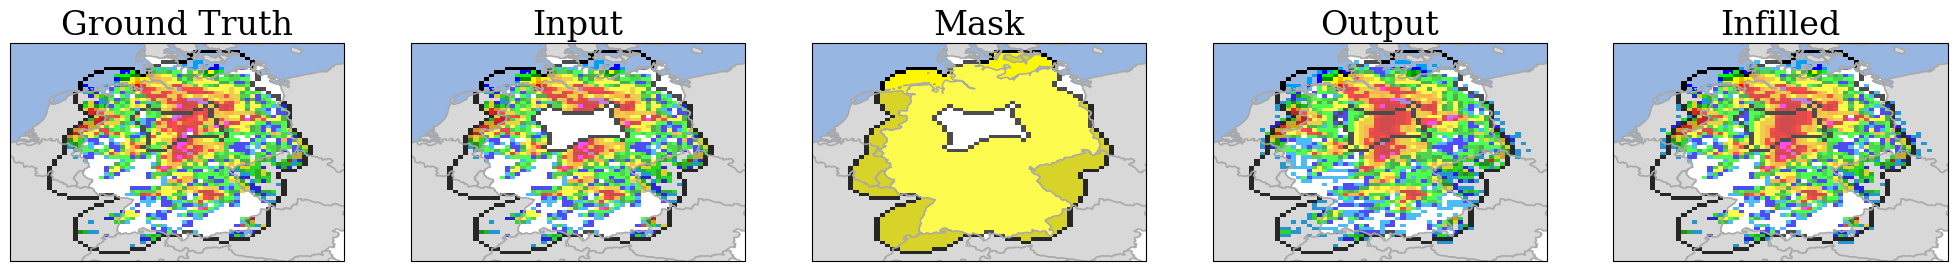

In [39]:
for iteration in infill_iterations:
    print("Iteration: {}".format(iteration))
    plot_results(gts, inputs, masks, outputs[iteration], infilled[iteration], dataset_val.xr_dss)

In [40]:
%%capture
create_video(infilled[infill_iterations[-1]], gts, masks, dataset_val.xr_dss)

<img src="crai_video.gif" width="1175" align="center">

In [4]:
ground_truth_values = xr.open_dataset("measurements/Testing/vienna_station_name.nc")  # Replace with your actual ground truth array
ground_truth_values.tas.values

array([[[288.05]],

       [[288.75]],

       [[289.05]],

       ...,

       [[294.95]],

       [[294.55]],

       [[294.35]]])

In [5]:
ds = xr.open_dataset("crai_radolan_ferdinand/train/vienna_t2m_2017-2024_data_cropped_era5_renamed.nc")
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12477, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 100kB 2017-04-24T14:00:00 ... 2022-05-24T1...
  * lon      (lon) float64 64B 15.5 15.75 16.0 16.25 16.5 16.75 17.0 17.25
  * lat      (lat) float64 64B 47.25 47.5 47.75 48.0 48.25 48.5 48.75 49.0
Data variables:
    tas      (time, lat, lon) float32 3MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Nov 05 16:21:00 2024: cdo chname,var167,tas crai_radola...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [9]:
class FillAllTasWithValuesInNcFile:
    def __init__(self, values, original_path, save_to_path):
        # Store values and paths
        self.values = values
        self.original_path = original_path
        self.save_to_path = save_to_path
        self._create_filled_nc_files()

    def _create_filled_nc_files(self):
        with xr.open_dataset(self.original_path) as ds:
            # Broadcasting values to the shape of 'tas'
            if isinstance(self.values, np.ndarray) and self.values.shape == (ds['tas'].shape[0], 1, 1):
                # Expand to (time, lat, lon) for each timestep
                self.values = np.broadcast_to(self.values, ds['tas'].shape)
            
            # Assign the values directly to 'tas' in the dataset
            ds['tas'].values = self.values
            ds.to_netcdf(self.save_to_path)

In [10]:
import xarray as xr
import numpy as np


# Paths to your input and target files
era5_input_path = "crai_radolan_ferdinand/train/vienna_t2m_2017-2024_data_cropped_era5_renamed.nc"  # Replace with the actual path to your ERA5 data
ground_truth = xr.open_dataset("measurements/Testing/vienna_station_name.nc")  # Replace with your actual ground truth array
ground_truth_values = ground_truth.tas.values

# Generate the target NetCDF file based on your ground truth array
target_output_path = "crai_radolan_ferdinand/train/groundtruth.nc"
FillAllTasWithValuesInNcFile(values=ground_truth_values, original_path=era5_input_path, save_to_path=target_output_path)


In [25]:
train_args = {
    "data_root_dir": "crai_radolan_ferdinand/",
    "data_names": "vienna_t2m_2017-2024_data_cropped_era5_renamed.nc,groundtruth.nc",
    "data_types": "tas,tas",
    "n_target_data": 1,
    "encoding_layers": 3,
    "pooling_layers": 0,
    "device": "cpu",  # Set to "cuda" if using a GPU
    "n_filters": 18,
    "out_channels": 1,
    "snapshot_dir": "crai_radolan_ferdinand/snap",
    "n_threads": 0,
    "max_iter": 2000,  # Set the desired number of iterations
    "log_interval": 10,  # Adjust log interval as needed
    "eval_timesteps": "0,1",
    "loss_criterion": 3,
    "log_dir": "crai_radolan_ferdinand/log",
    "normalize_data": True,
}


In [26]:
train_args_path = "crai_radolan_ferdinand/train_args.txt"

with open(train_args_path, 'w') as f:
    for key, value in train_args.items():
        f.write(f"--{key.replace('_', '-')} {value}\n")

In [17]:
from crai.climatereconstructionai import train

train(train_args_path)

FileNotFoundError: [Errno 2] No such file or directory: "['--data-root-dir', 'crai_radolan_ferdinand/train/', '--data-names', 'era5_input.nc,groundtruth.nc', '--data-types', 'tas,tas', '--n-target-data', '1', '--encoding-layers', '3', '--device', 'cpu', '--max-iter', '1000']"

In [75]:
import torch
from crai.climatereconstructionai.model.net import CRAINet
from crai.climatereconstructionai.utils.netcdfloader import NetCDFLoader, FiniteSampler
from crai.climatereconstructionai.utils.io import load_ckpt, load_model
from torch.utils.data import DataLoader

# Load the model checkpoint and configuration
model_path = "crai_radolan_ferdinand/snap/ckpt/final.pth"
ckpt_dict = load_ckpt(model_path, device="cpu")  # Use "cuda" if running on GPU
data_stats = ckpt_dict.get("train_stats", None)

# Define your dataset for evaluation
dataset_val = NetCDFLoader(
    data_root="crai_radolan_ferdinand",
    img_names=["vienna_t2m_2017-2024_data_cropped_era5_renamed.nc", "groundtruth.nc"],
    mask_root=None,
    mask_names=None,
    split="train",
    data_types=["tas", "tas"],
    time_steps=[0, 0],
    train_stats=data_stats
)


In [42]:
from crai.climatereconstructionai.utils.netcdfloader import NetCDFLoader

# Load dataset to get bounds
dataset_train = NetCDFLoader(
    data_root="crai_radolan_ferdinand/",
    img_names=["vienna_t2m_2017-2024_data_cropped_era5_renamed.nc"],
    mask_root=None,
    mask_names=None,
    split="train",
    data_types=["tas"],
    time_steps=[0, 0]
)

# Retrieve bounds from the dataset
bounds = dataset_train.bounds  # Assuming bounds are calculated and accessible here
print(dataset_train.img_sizes[0])


AttributeError: module 'crai.climatereconstructionai.config' has no attribute 'lazy_load'

In [77]:
# Retrieve image size from the dataset
image_sizes = dataset_val.img_sizes
bounds = dataset_val.bounds  # Use bounds calculated during training

# Define the model
model = CRAINet(
    img_size=image_sizes[0],
    enc_dec_layers=3,
    pool_layers=0,
    in_channels=1,
    out_channels=1,
    bounds=bounds
).to("cpu")  # or "cuda" if you are using a GPU

# Load model weights
load_model(ckpt_dict, model)
model.eval()  # Set model to evaluation mode
print(model)

CRAINet(
  (encoder): ModuleList(
    (0): EncoderBlock(
      (partial_conv): PConvBlock(
        (input_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (mask_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (activation): ReLU()
      )
    )
    (1): EncoderBlock(
      (partial_conv): PConvBlock(
        (input_conv): Conv2d(18, 36, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (mask_conv): Conv2d(18, 36, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (activation): ReLU()
        (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): EncoderBlock(
      (partial_conv): PConvBlock(
        (input_conv): Conv2d(36, 72, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (mask_conv): Conv2d(36, 72, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (activation): ReLU()
        (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [83]:
# Define batch size based on memory or desired inference speed
batch_size = 16  # Set batch size appropriately
dataloader = DataLoader(dataset_val, batch_size=batch_size, sampler=FiniteSampler(len(dataset_val)), num_workers=0)
for batch in dataloader:
    print(batch)
    break  # Print only the first batch

predictions = []

[tensor([[[[[ 4.6846e-01,  4.7575e-01,  4.7667e-01,  ...,  5.9651e-01,
             6.1048e-01,  5.7434e-01],
           [ 9.0890e-02,  1.6010e-01,  3.0855e-01,  ...,  5.7766e-01,
             6.0669e-01,  5.8466e-01],
           [ 6.2959e-02,  1.6629e-01,  3.6634e-01,  ...,  6.1121e-01,
             6.0298e-01,  5.6772e-01],
           ...,
           [ 3.5554e-01,  4.4199e-01,  4.9509e-01,  ...,  4.9757e-01,
             4.4486e-01,  3.9631e-01],
           [ 2.9174e-01,  3.3755e-01,  3.9614e-01,  ...,  4.8337e-01,
             4.3622e-01,  3.5847e-01],
           [ 2.2238e-01,  2.7301e-01,  3.3211e-01,  ...,  3.9937e-01,
             3.7064e-01,  3.2351e-01]]]],



        [[[[ 4.8746e-01,  5.2346e-01,  5.5578e-01,  ...,  6.7276e-01,
             6.6583e-01,  6.1732e-01],
           [ 1.1247e-01,  2.0311e-01,  3.7675e-01,  ...,  6.4913e-01,
             6.6401e-01,  6.3531e-01],
           [-2.5873e-02,  8.8640e-02,  4.0995e-01,  ...,  6.6948e-01,
             6.6021e-01,  6.2890e-0

In [86]:
predictions = []
# Assuming the batch structure is [inputs, input_mask, targets, ...]
for batch in dataloader:
    inputs, input_mask, targets, *extra = batch  # Unpack inputs, mask, and targets
    
    # Pass both `inputs` and `input_mask` to the model
    outputs = model(inputs, input_mask)
    
    # Collect the outputs (e.g., convert to numpy or process as needed)
    predictions.append(outputs.detach().numpy())


In [87]:
predictions

[array([[[[[ 0.35180187,  0.35699967,  0.35763434, ...,  0.3588912 ,
             0.35841164,  0.3522525 ],
           [ 0.36082956,  0.3622485 ,  0.36337918, ...,  0.3653783 ,
             0.36473   ,  0.35801172],
           [ 0.3591689 ,  0.3611057 ,  0.36259437, ...,  0.364783  ,
             0.3638259 ,  0.35694525],
           ...,
           [ 0.35923582,  0.36053827,  0.3610209 , ...,  0.36160305,
             0.36027172,  0.35334742],
           [ 0.35629857,  0.35773903,  0.35838148, ...,  0.35975683,
             0.35845077,  0.35150704],
           [ 0.35416123,  0.35671628,  0.35738775, ...,  0.35943985,
             0.35808083,  0.3523426 ]]]],
 
 
 
        [[[[ 0.3850584 ,  0.39112386,  0.39238435, ...,  0.39450905,
             0.39384648,  0.38717914],
           [ 0.39424062,  0.39636528,  0.39832032, ...,  0.40149724,
             0.4007596 ,  0.39355603],
           [ 0.39139834,  0.39430955,  0.39694172, ...,  0.40079787,
             0.3998969 ,  0.3926205 ],
   

In [47]:
# Define and load the model for evaluation


model_path = "crai_radolan_ferdinand/snap/ckpt/best.pth"  # Replace with actual snapshot path
model = CRAINet(img_size=dataset_train.img_sizes[0],
                enc_dec_layers=3,
                pool_layers=0,
                in_channels=1,
                out_channels=1,
                bounds=bounds)


# Load model weights
model.load_state_dict(torch.load(model_path))
model.eval()


RuntimeError: Error(s) in loading state_dict for CRAINet:
	Missing key(s) in state_dict: "encoder.0.partial_conv.input_conv.weight", "encoder.0.partial_conv.mask_conv.weight", "encoder.1.partial_conv.input_conv.weight", "encoder.1.partial_conv.mask_conv.weight", "encoder.1.partial_conv.bn.weight", "encoder.1.partial_conv.bn.bias", "encoder.1.partial_conv.bn.running_mean", "encoder.1.partial_conv.bn.running_var", "encoder.2.partial_conv.input_conv.weight", "encoder.2.partial_conv.mask_conv.weight", "encoder.2.partial_conv.bn.weight", "encoder.2.partial_conv.bn.bias", "encoder.2.partial_conv.bn.running_mean", "encoder.2.partial_conv.bn.running_var", "decoder.0.partial_conv.input_conv.weight", "decoder.0.partial_conv.mask_conv.weight", "decoder.0.partial_conv.bn.weight", "decoder.0.partial_conv.bn.bias", "decoder.0.partial_conv.bn.running_mean", "decoder.0.partial_conv.bn.running_var", "decoder.1.partial_conv.input_conv.weight", "decoder.1.partial_conv.mask_conv.weight", "decoder.1.partial_conv.bn.weight", "decoder.1.partial_conv.bn.bias", "decoder.1.partial_conv.bn.running_mean", "decoder.1.partial_conv.bn.running_var", "decoder.2.partial_conv.input_conv.weight", "decoder.2.partial_conv.input_conv.bias", "decoder.2.partial_conv.mask_conv.weight". 
	Unexpected key(s) in state_dict: "labels", "train_stats", "2000". 

In [49]:
# Load the checkpoint file to inspect its structure
checkpoint = torch.load("executed_trainings/Marshall_20240521-1849/model_23109ufy/ckpt/final.pth")
print(checkpoint.keys())

dict_keys(['labels', 'train_stats', '300000'])


In [67]:
eval_args_path = "crai_radolan_ferdinand/eval_args.txt"

# Specify your evaluation arguments
eval_args = f"""
--data-root-dir crai_radolan_ferdinand
--model-dir crai_radolan_ferdinand/snap/ckpt
--model-names final.pth  # or best.pth, replace with your specific checkpoint name
--data-names era5_data.nc,groundtruth.nc
--data-types tas,tas
--n-target-data 1
--pooling-layers 0
--evaluation-dirs crai_radolan_ferdinand/output  # Directory for evaluation outputs
--log-dir crai_radolan_ferdinand/logs  # Directory for logging evaluation metrics
--device cpu
--n-filters 18
--out-channels 1
--loss-criterion 3
--normalize-data
--use-train-stats
""".strip()

# Write eval_args to a file
with open(eval_args_path, 'w') as f:
    f.write(eval_args)


In [68]:
from crai.climatereconstructionai.evaluate import evaluate

# Run evaluation
evaluate(eval_args_path)


100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


Extracting Vienna_station_name...


100%|██████████| 1857/1857 [01:29<00:00, 20.69it/s]


displaying lon: 16.3609
as 16.361


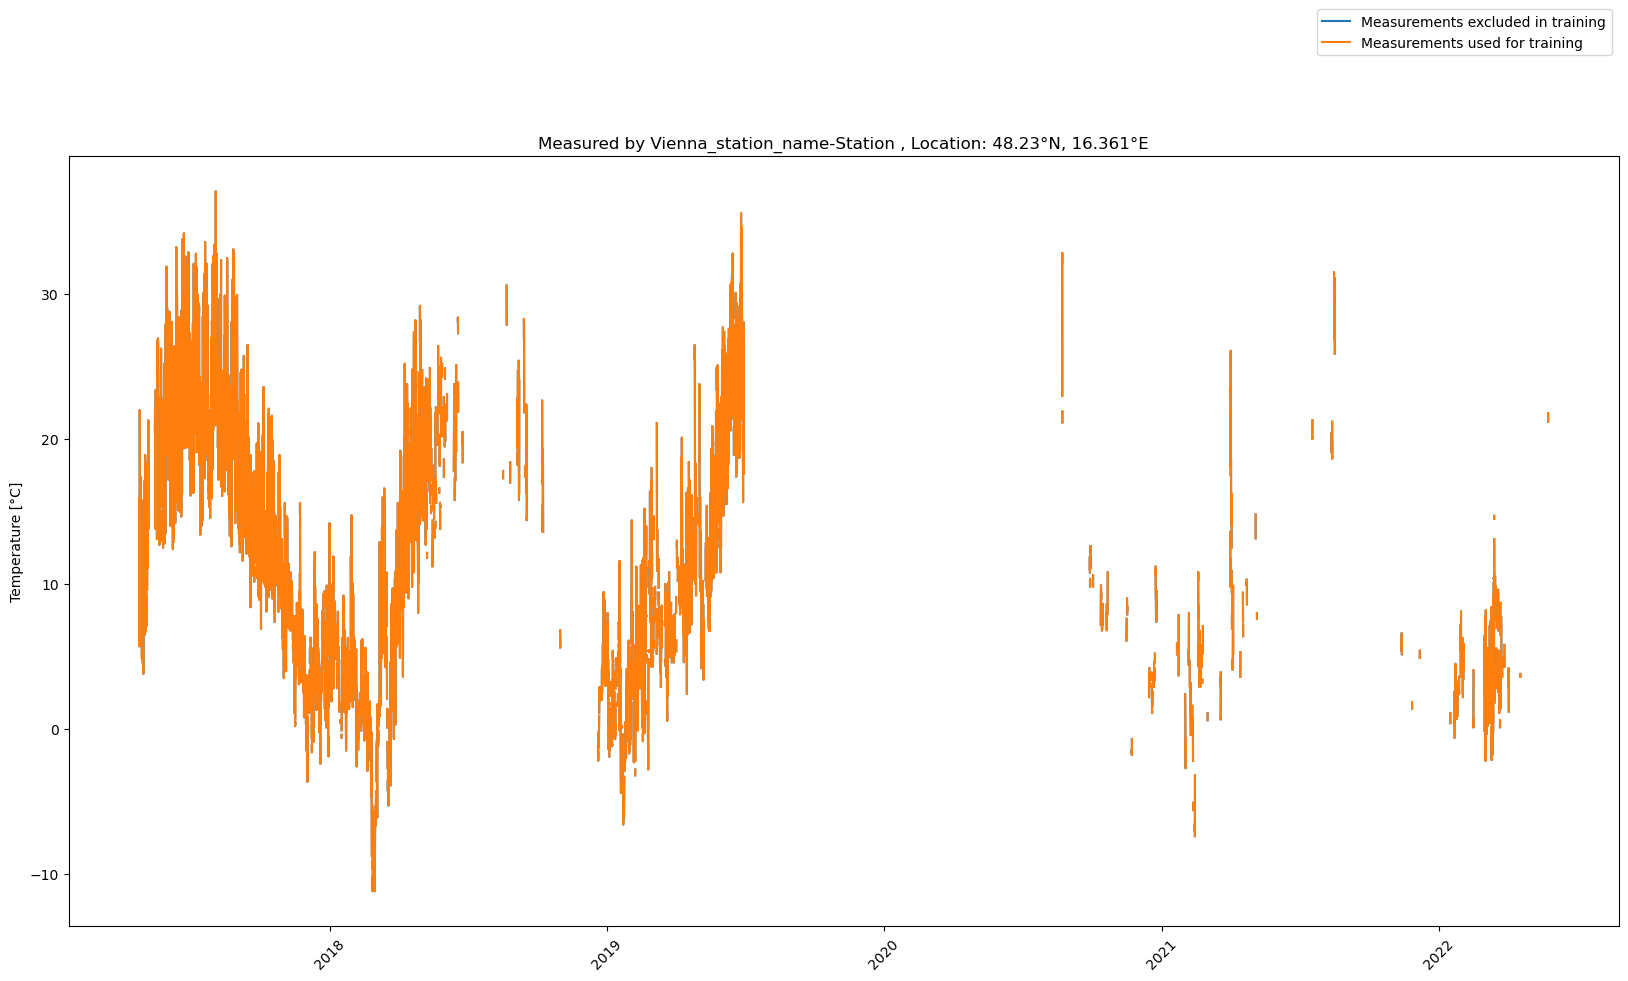

In [2]:
from station.station import StationData

# Initialize the station data
# Processes all dat files, extracts metadata cleans data uses DattoNxConverter
vienna_station = StationData(
    name='Vienna_station_name',
    folder_path='measurements/Vienna',
    #mask_years=[2020]  # Optionally mask out certain years
)

In [4]:
from station.station import StationData
from utils.utils import ProgressStatus
from train_station_twin.validation_executor import ValidationExecutor

# Path to your trained model
model_path = "/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/crai_radolan_ferdinand/snap/ckpt/best.pth"

# Initialize progress status
progress = ProgressStatus()

# Create an instance of ValidationExecutor to perform validation
validator = ValidationExecutor(
    station=vienna_station,
    model_path=model_path,
    progress=progress
)

# Retrieve the paths to the generated reports
pdf_report, csv_report = validator.validate()

print(f"Validation PDF Report: {pdf_report}")
print(f"Validation CSV Report: {csv_report}")

# Optionally, create a ZIP archive of all validation results
zip_path = validator.make_zip()
print(f"Validation ZIP Archive: {zip_path}")


(12477,) hourly temperature values in dataframe
Saving to /var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/tmpv39b_iag/vienna_station_name.nc
Using URL: https://cds-beta.climate.copernicus.eu/api
Downloading... 2017


2024-11-06 12:30:55,940 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-06 12:30:55,941 INFO Request ID is 6773bafb-b91b-4891-a3ce-81f77c6690b5
2024-11-06 12:30:56,048 INFO status has been updated to accepted


KeyboardInterrupt: 

In [7]:
import xarray as xr

ds = xr.open_dataset("crai_radolan_ferdinand/train/vienna_t2m_2017-2024_data_cropped_era5_renamed.nc")
ds2 = xr.open_dataset( "crai_radolan_ferdinand/train/groundtruth.nc")

In [8]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12477, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 100kB 2017-04-24T14:00:00 ... 2022-05-24T1...
  * lon      (lon) float64 64B 15.5 15.75 16.0 16.25 16.5 16.75 17.0 17.25
  * lat      (lat) float64 64B 47.25 47.5 47.75 48.0 48.25 48.5 48.75 49.0
Data variables:
    tas      (time, lat, lon) float32 3MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Nov 05 16:21:00 2024: cdo chname,var167,tas crai_radola...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [9]:
ds2

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12477, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 100kB 2017-04-24T14:00:00 ... 2022-05-24T1...
  * lon      (lon) float64 64B 15.5 15.75 16.0 16.25 16.5 16.75 17.0 17.25
  * lat      (lat) float64 64B 47.25 47.5 47.75 48.0 48.25 48.5 48.75 49.0
Data variables:
    tas      (time, lat, lon) float32 3MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Nov 05 16:21:00 2024: cdo chname,var167,tas crai_radola...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [10]:
from train_station_twin.training_executor_copy import SimplifiedTrainingExecutor

# Set the data root directory and model output directory
data_root_dir = 'simplified_training/Data'  # Replace with your data directory
model_output_dir = 'simplified_training/'  # Replace with your desired output directory

# Create an instance of the training executor
executor = SimplifiedTrainingExecutor(data_root_dir, model_output_dir, max_iter=1000, device='cpu')

# Execute the training
executor.prepare_arguments()




Training arguments written to simplified_training/train_args.txt


In [18]:
# run_evaluation.py
from crai.climatereconstructionai.train import train

import sys

# Save the original sys.argv
original_argv = sys.argv.copy()
train_args_path = "simplified_training_copy/train_args.txt"

# Set sys.argv to include only the necessary arguments
sys.argv = ['ipykernel_launcher.py', '--load-from-file', train_args_path]


train_args_path = "simplified_training_copy/train_args.txt"

# Run evaluation
train()

* Number of GPUs:  0


lr = 2.0e-04:  10%|▉         | 99/1000 [00:05<00:47, 19.00it/s]


In [2]:
# Execute the training
executor.execute_training()

Training arguments written to simplified_training/train_args.txt


FileNotFoundError: [Errno 2] No such file or directory: "['--data-root-dir', 'simplified_training/Data', '--data-names', 'input_data.nc,ground_truth.nc', '--data-types', 'tas,tas', '--n-target-data', '1', '--encoding-layers', '3', '--pooling-layers', '0', '--device', 'cpu', '--n-filters', '18', '--out-channels', '1', '--snapshot-dir', 'simplified_training/', '--n-threads', '0', '--max-iter', '1000', '--log-interval', '10', '--eval-timesteps', '0,1', '--loss-criterion', '3', '--log-dir', 'simplified_training/logs', '--normalize-data', 'True', '--early-stopping-patience', '10']"

In [14]:
# run_evaluation.py
from crai.climatereconstructionai.train import train

eval_args_path = "simplified_training/train_args.txt"

# Run evaluation
train(eval_args_path)

"""output_output.nc: This file contains the model's output predictions. Specifically, it includes the infilled or reconstructed data produced by your trained model when applied to the test data specified in your evaluation arguments.
output_gt.nc: This file contains the ground truth data corresponding to your test dataset. It is generated during evaluation for comparison purposes."""

usage: ipykernel_launcher.py [-h] [--data-root-dir DATA_ROOT_DIR]
                             [--mask-dir MASK_DIR] [--log-dir LOG_DIR]
                             [--data-names DATA_NAMES]
                             [--mask-names MASK_NAMES]
                             [--data-types DATA_TYPES]
                             [--n-target-data N_TARGET_DATA] [--device DEVICE]
                             [--shuffle-masks] [--channel-steps CHANNEL_STEPS]
                             [--lstm-steps LSTM_STEPS] [--gru-steps GRU_STEPS]
                             [--encoding-layers ENCODING_LAYERS]
                             [--pooling-layers POOLING_LAYERS]
                             [--conv-factor CONV_FACTOR] [--weights WEIGHTS]
                             [--steady-masks STEADY_MASKS]
                             [--loop-random-seed LOOP_RANDOM_SEED]
                             [--cuda-random-seed CUDA_RANDOM_SEED]
                             [--deterministic] [--attention]
  

SystemExit: 2

In [15]:
# run_evaluation.py
from crai.climatereconstructionai.evaluate import evaluate

eval_args_path = "simplified_training/eval_args.txt"

# Run evaluation
evaluate(eval_args_path)

"""output_output.nc: This file contains the model's output predictions. Specifically, it includes the infilled or reconstructed data produced by your trained model when applied to the test data specified in your evaluation arguments.
output_gt.nc: This file contains the ground truth data corresponding to your test dataset. It is generated during evaluation for comparison purposes."""

100%|██████████| 1/1 [00:07<00:00,  7.88s/it]


"output_output.nc: This file contains the model's output predictions. Specifically, it includes the infilled or reconstructed data produced by your trained model when applied to the test data specified in your evaluation arguments.\noutput_gt.nc: This file contains the ground truth data corresponding to your test dataset. It is generated during evaluation for comparison purposes."

In [82]:
import xarray as xr
ds = xr.open_dataset("simplified_training/output_evaluation/output_output.nc")
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (lon: 8, lat: 8, time: 12477)
Coordinates:
  * lon      (lon) float64 64B 15.5 15.75 16.0 16.25 16.5 16.75 17.0 17.25
  * lat      (lat) float64 64B 47.25 47.5 47.75 48.0 48.25 48.5 48.75 49.0
  * time     (time) datetime64[ns] 100kB 2017-04-24T14:00:00 ... 2022-05-24T1...
Data variables:
    tas      (time, lat, lon) float32 3MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Infilled using CRAI (Climate Reconstruction AI: https://git...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [84]:
model_path = "simplified_training/ckpt/final.pth"
ckpt_dict = load_ckpt(model_path, device="cpu")  # Use "cuda" if running on GPU
data_stats = ckpt_dict.get("train_stats", None)

# Define your dataset for evaluation
dataset_val = NetCDFLoader(
    data_root="simple_training/Data",  
    img_names=["input_data.nc", "ground_truth.nc"],
    mask_root=None,
    mask_names=None,
    split="train",
    data_types=["tas", "tas"],
    time_steps=[0, 0],
    train_stats=data_stats
)

File simple_training/Data/train/input_data.nc not found.


ValueError: Impossible to read input_data.nc.
Please, check that it is a netCDF file and it is not corrupted.

In [74]:
# Save the original sys.argv
original_argv = sys.argv.copy()

# Override sys.argv
sys.argv = ['dummy_script_name'] + arg_list

cfg.set_evaluate_args()


In [75]:
# Restore sys.argv
sys.argv = original_argv


In [77]:
# Ensure that encoding_layers and pooling_layers are integers
enc_dec_layers = int(cfg.encoding_layers[0]) if isinstance(cfg.encoding_layers, list) else int(cfg.encoding_layers)
pool_layers = int(cfg.pooling_layers[0]) if isinstance(cfg.pooling_layers, list) else int(cfg.pooling_layers)

# Initialize the model
img_size = (8, 8)  # Replace with the actual image size used during training
model = CRAINet(
    img_size=img_size,
    enc_dec_layers=enc_dec_layers,
    pool_layers=pool_layers,
    in_channels=cfg.in_channels,
    out_channels=cfg.out_channels
).to(cfg.device)


TypeError: unsupported operand type(s) for //: 'NoneType' and 'int'

In [65]:
import os
import torch
from crai.climatereconstructionai import config as cfg
from crai.climatereconstructionai.config import set_common_args, global_args
from crai.climatereconstructionai.model.net import CRAINet
from crai.climatereconstructionai.utils.io import load_ckpt, load_model
import matplotlib.pyplot as plt
import numpy as np

arg_list = [
    '--data-root-dir', 'simplified_training/Data',
    '--data-names', 'input_data.nc,ground_truth.nc',
    '--data-types', 'tas,tas',
    '--encoding-layers', '3',
    '--pooling-layers', '0',
    '--device', 'cpu',
    '--out-channels', '1',
    '--in-channels', '1',
    '--n-target-data', '1'  # Adjust based on your setup
]

cfg.set_evaluate_args(arg_list)



FileNotFoundError: [Errno 2] No such file or directory: "['--data-root-dir', 'simplified_training/Data', '--data-names', 'input_data.nc,ground_truth.nc', '--data-types', 'tas,tas', '--encoding-layers', '3', '--pooling-layers', '0', '--device', 'cpu', '--out-channels', '1', '--in-channels', '1', '--n-target-data', '1']"

In [55]:
from torch.utils.tensorboard import SummaryWriter

# Initialize the SummaryWriter
writer = SummaryWriter(log_dir=cfg.log_dir)

# During training, after computing the loss
writer.add_scalar('Loss/Train', train_loss, iteration)
writer.add_scalar('Loss/Validation', val_loss, iteration)



AttributeError: module 'crai.climatereconstructionai.config' has no attribute 'log_dir'

In [51]:
ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()

# Get the list of tags
tags = ea.Tags()['scalars']
print("Available tags:", tags)


Available tags: []


In [54]:
from crai.climatereconstructionai import config as cfg

cfg.set_train_args(args_list="/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/simplified_training/train_args.txt")



TypeError: set_train_args() got an unexpected keyword argument 'args_list'

In [38]:
from crai.climatereconstructionai import config as cfg

# Configuration attributes required by the model
cfg.n_filters = 18  # Same as during training
cfg.conv_factor = 1  # Set to 1 if not specified during training
cfg.n_target_data = 1  # Number of target data variables
cfg.bounds = None  # Set to None or actual bounds if available
cfg.attention = False  # Set to False unless you used attention during training
cfg.normalize_data = True  # Set if data normalization was used
cfg.loss_criterion = 3  # Same as during training
cfg.data_types = ['tas', 'tas']  # Same as during training
cfg.global_padding = False  # Set to False unless used during training
cfg.disable_first_bn = False  # Set to False unless used during training
cfg.disable_skip_layers = False  # Set to False unless used during training
cfg.masked_bn = False  # Set to False unless used during training
cfg.profile = False  # Set to True if profiling was used during training
cfg.recurrent_steps = 0  # Set based on training configuration
cfg.n_recurrent_steps = 1  # Set based on training configuration
cfg.n_channel_steps = 1  # Set based on training configuration
cfg.gt_channels = [0]  # Set based on training configuration
cfg.skip_layers = 1 if not cfg.disable_skip_layers else 0
cfg.deterministic = False  # Set to True if deterministic mode was used
cfg.dataset_name = None  # Set if used during training
cfg.n_recurrent_steps = 1
cfg.weights = None  # Set to None or the path to weights if used
cfg.loop_random_seed = 42  # Set to an integer for reproducibility


In [41]:
import torch
from crai.climatereconstructionai.model.net import CRAINet
from crai.climatereconstructionai.utils.io import load_model

device = 'cpu'  # or 'cuda' if using GPU

# Define the model parameters
img_size = (8, 8)  # Replace with your actual image size
enc_dec_layers = 3
pooling_layers = 0
in_channels = 1
out_channels = 1

# Initialize the model
model = CRAINet(
    img_size=img_size,
    enc_dec_layers=enc_dec_layers,
    pool_layers=pooling_layers,
    in_channels=in_channels,
    out_channels=out_channels,
    bounds=cfg.bounds
).to(device)

print("Model initialized successfully.")


AttributeError: module 'crai.climatereconstructionai.config' has no attribute 'lstm_steps'

In [14]:
device = 'cpu'  # or 'cuda' if using GPU

# Define the model parameters
img_size = (8, 8)  # Replace with your actual image size
enc_dec_layers = 3
pooling_layers = 0
in_channels = 1
out_channels = 1

# Initialize the model
model = CRAINet(
    img_size=img_size,
    enc_dec_layers=enc_dec_layers,
    pool_layers=pooling_layers,
    in_channels=in_channels,
    out_channels=out_channels,
    bounds=None  # Use actual bounds if available
).to(device)

AttributeError: module 'crai.climatereconstructionai.config' has no attribute 'global_padding'

In [27]:
from tensorboard.backend.event_processing import event_accumulator

# Path to the logs directory
log_dir = 'simplified_training/logs'

# Find the event file
event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events.out.tfevents' in f]
assert event_files, "No TensorBoard event files found in the log directory."
event_file = event_files[0]  # Adjust if you have multiple event files

# Load the event file
ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()

# Get the list of tags
tags = ea.Tags()['scalars']
print("Available tags:", tags)

# Adjust these tags based on your logging setup
# For example, if your training and validation loss are logged under 'Loss/Train' and 'Loss/Validation'
train_loss_tag = 'train/loss'       # Replace with the actual tag for training loss
val_loss_tag = 'val/loss'    # Replace with the actual tag for validation loss

# Extract the scalar events
train_loss_events = ea.Scalars(train_loss_tag)
val_loss_events = ea.Scalars(val_loss_tag)

# Extract steps and values
train_steps = [event.step for event in train_loss_events]
train_values = [event.value for event in train_loss_events]

val_steps = [event.step for event in val_loss_events]
val_values = [event.value for event in val_loss_events]

# Plot the losses
plt.figure()
plt.plot(train_steps, train_values, label='Train Loss')
plt.plot(val_steps, val_values, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Available tags: []


KeyError: 'Key train/loss was not found in Reservoir'

In [4]:
# Import necessary modules
import torch
import os

# Import the model architecture
from crai.climatereconstructionai.model.net import CRAINet

# Set the device (CPU or GPU)
device = 'cpu'  # or 'cuda' if you have a GPU and want to use it

# Define the model parameters (must match the ones used during training)
img_size = (8, 8)  # Replace with your actual image size
enc_dec_layers = 3
pooling_layers = 0
in_channels = 1  # Adjust based on your data
out_channels = 1

# Initialize the model
model = CRAINet(
    img_size=img_size,
    enc_dec_layers=enc_dec_layers,
    pool_layers=pooling_layers,
    in_channels=in_channels,
    out_channels=out_channels
).to(device)

# Path to the trained model
model_path = 'simplified_training/ckpt/best.pth'

# Check if the model file exists
assert os.path.exists(model_path), f"Model file not found at {model_path}"

# Load the checkpoint
checkpoint = torch.load(model_path, map_location=device)

# Inspect the checkpoint to find the correct key for the model state dict
print("Checkpoint keys:", checkpoint.keys())

# Exclude 'train_stats' from the keys to get model entries
model_keys = [key for key in checkpoint.keys() if key != 'train_stats']
print("Model entries in checkpoint:", model_keys)

# Assuming there's only one model saved, get its key
# If multiple models are saved (e.g., at different iterations), choose the desired one
model_entry_key = model_keys[0]  # Adjust this if necessary

# Get the model state dict
model_state_dict = checkpoint[model_entry_key]['model_state_dict']

# Load the state dict into the model
model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully.")


AttributeError: module 'crai.climatereconstructionai.config' has no attribute 'n_filters'